# Gesture CNN → Robot Commands (Notebook)

*Hi! This is a full, end‑to‑end notebook for collecting data, training a CNN,
evaluating it, and running a realtime loop that sends commands to an Arduino Mega.*

**What I'll do here:**
1) Inspect & split the dataset (train/val/test)
2) Train a lightweight CNN (ResNet‑18)
3) Evaluate with accuracy, F1, and a confusion matrix
4) (Optional) Export to ONNX
5) Realtime webcam inference + send 1‑byte opcodes to Arduino over serial

**Tip:** Run each section top‑to‑bottom. Keep the Arduino code simple for now: it just reads one byte and triggers motions.

## 0) Setup
We install the things we need (PyTorch, torchvision, OpenCV, pyserial, scikit‑learn).
If you already have them, you can skip this cell. Run it once on your local machine.

In [2]:
%pip install torch torchvision torchaudio --upgrade --quiet
%pip install opencv-python pyserial scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1) Config & Globals
Let’s define paths, image size, batch sizes, and the list of gesture classes.
Keep this in one place so you can tweak easily (e.g., change dataset folder).

In [2]:
from pathlib import Path

# Where the merged dataset lives after running the merge script.
# Expected structure:
# dataset/
#   open_palm/*.jpg
#   fist/*.jpg
#   thumbs_up/*.jpg
#   two_fingers/*.jpg
#   point_left/*.jpg
#   point_right/*.jpg
DATASET_DIR = Path('/Users/hugoarsenio1/Desktop/dataset')

# Where we'll write the split (train/val/test)
SPLIT_DIR = Path('/Users/hugoarsenio1/Desktop/data_split')

# Classes (folders) expected in DATASET_DIR
CLASSES = [
    'open_palm', 'fist', 'thumbs_up', 'two_fingers', 'point_left', 'point_right'
]

# Image size and training hyperparams
IMSIZE = 224
BATCH  = 32
EPOCHS = 30
LR     = 3e-4
NUM_WORKERS = 2

MODEL_CKPT = Path('gesture_resnet18_best.pt')


## 2) Quick data sanity check
Before splitting and training, let’s just count files per class and peek at a couple of random images.
If any class looks way smaller, consider collecting more or augmenting during training.

Image counts per gesture:
open_palm: 1061
fist: 1060
thumbs_up: 1048
two_fingers: 1096
point_left: 868
point_right: 807


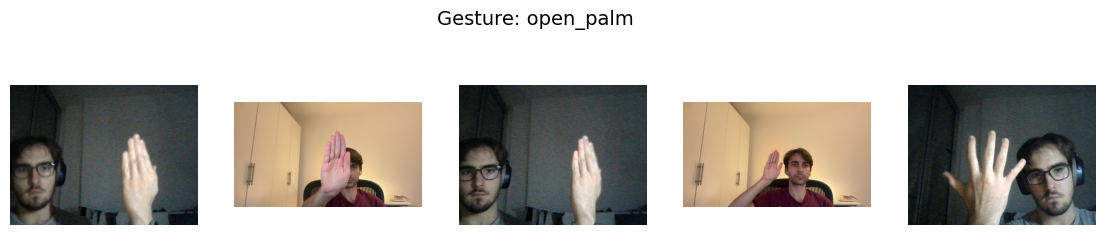

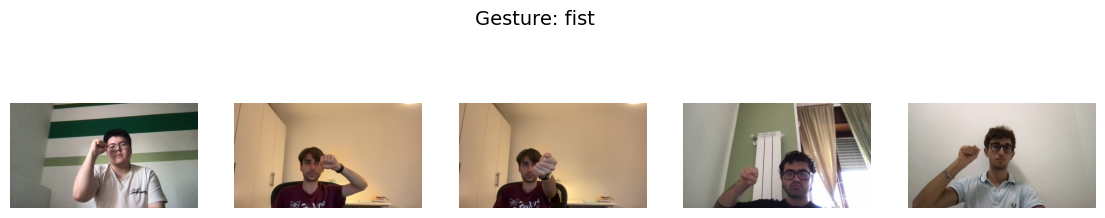

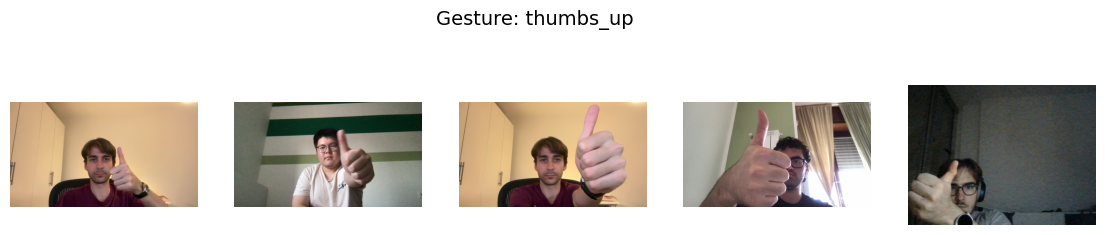

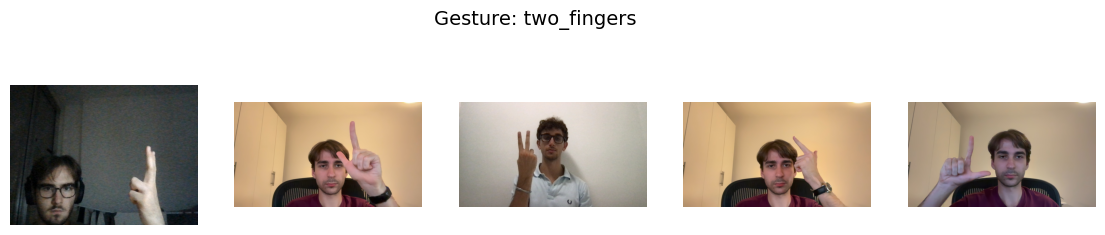

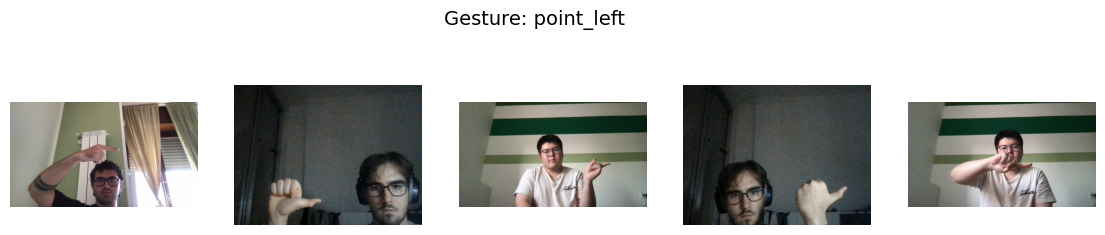

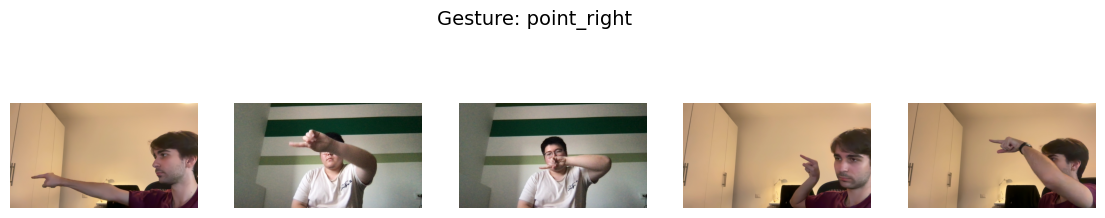

In [4]:
import os, random, cv2
import matplotlib.pyplot as plt

counts = {}
for cls in CLASSES:
    folder = DATASET_DIR/cls
    if not folder.exists():
        print(f'Missing folder: {folder}')
        counts[cls] = 0
        continue
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    counts[cls] = len(files)

print('Image counts per gesture:')
for k,v in counts.items():
    print(f'{k}: {v}')

# Visual sample: up to 5 images per class
for cls in CLASSES:
    folder = DATASET_DIR/cls
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if not files:
        continue
    sample = random.sample(files, min(5, len(files)))
    fig, axes = plt.subplots(1, len(sample), figsize=(14,3))
    fig.suptitle(f'Gesture: {cls}', fontsize=14)
    for ax, fname in zip(axes, sample):
        img = cv2.imread(str(folder/fname))
        if img is None:
            ax.axis('off'); continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img); ax.axis('off')
    plt.show()


## 3) Split into train / val / test
Here we create a clean split (75% train, 15% val, 10% test) into a new folder `data_split/`.
Splitting is important so you can measure generalization without leaking test images into training.

In [5]:
import shutil, random

random.seed(42)
for split in ['train','val','test']:
    for cls in CLASSES:
        (SPLIT_DIR/split/cls).mkdir(parents=True, exist_ok=True)

for cls in CLASSES:
    src = DATASET_DIR/cls
    files = [p for p in src.glob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png')]
    random.shuffle(files)
    n = len(files)
    n_train = int(n*0.75)
    n_val   = int(n*0.15)
    parts = {
        'train': files[:n_train],
        'val':   files[n_train:n_train+n_val],
        'test':  files[n_train+n_val:]
    }
    for split, items in parts.items():
        for f in items:
            shutil.copy2(f, SPLIT_DIR/split/cls/f.name)

print('Split complete →', SPLIT_DIR)

Split complete → /Users/hugoarsenio1/Desktop/data_split


## 4) Train a ResNet‑18 (lightweight, effective)
We’ll fine‑tune an ImageNet‑pretrained ResNet‑18. It’s fast on CPU and good enough to get solid accuracy.
I also use class‑weighted loss so underrepresented gestures aren’t ignored.

In [6]:
import torch, numpy as np
from torchvision import datasets, transforms, models
from torch import nn
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cpu')  # Use 'cuda' if you have a GPU

tfm_train = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
tfm_eval = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(SPLIT_DIR/'train', transform=tfm_train)
val_ds   = datasets.ImageFolder(SPLIT_DIR/'val',   transform=tfm_eval)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS)

num_classes = len(train_ds.classes)

# Class weights
y_train = [y for _,y in train_ds.samples]
cls_weights = compute_class_weight(class_weight='balanced',
                                   classes=np.arange(num_classes),
                                   y=y_train)
cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

# Model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.fc.in_features, num_classes)
)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_val = 0.0
patience, bad = 5, 0

for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    tot, correct, loss_sum = 0, 0, 0.0
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward(); optimizer.step()
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); tot += y.size(0)
        loss_sum += loss.item()*y.size(0)
    tr_loss = loss_sum/tot; tr_acc = correct/tot

    # Val
    model.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x,y in val_dl:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            pred = logits.argmax(1)
            correct += (pred==y).sum().item(); tot += y.size(0)
            loss_sum += loss.item()*y.size(0)
    va_loss = loss_sum/tot; va_acc = correct/tot

    scheduler.step()
    print(f"[Epoch {epoch:02d}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

    if va_acc > best_val:
        best_val = va_acc
        torch.save({'state_dict': model.state_dict(), 'classes': train_ds.classes}, str(MODEL_CKPT))
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print('Early stopping.'); break

print('Training complete. Best model saved to', MODEL_CKPT)
print('Classes:', train_ds.classes)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/hugoarsenio1/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


[Epoch 01] train 0.3697/0.872 | val 0.1199/0.962
[Epoch 02] train 0.0831/0.977 | val 0.0441/0.984
[Epoch 03] train 0.0506/0.984 | val 0.0231/0.993
[Epoch 04] train 0.0331/0.989 | val 0.0220/0.992
[Epoch 05] train 0.0282/0.991 | val 0.0319/0.991
[Epoch 06] train 0.0295/0.991 | val 0.0092/0.996
[Epoch 07] train 0.0130/0.997 | val 0.0088/0.997
[Epoch 08] train 0.0153/0.995 | val 0.0124/0.996
[Epoch 09] train 0.0098/0.997 | val 0.0046/0.999
[Epoch 10] train 0.0040/0.999 | val 0.0004/1.000
[Epoch 11] train 0.0116/0.996 | val 0.0054/0.998
[Epoch 12] train 0.0137/0.996 | val 0.0036/0.999
[Epoch 13] train 0.0360/0.989 | val 0.0046/0.999
[Epoch 14] train 0.0111/0.997 | val 0.0070/0.997
[Epoch 15] train 0.0121/0.997 | val 0.0051/0.999
Early stopping.
Training complete. Best model saved to gesture_resnet18_best.pt
Classes: ['fist', 'open_palm', 'point_left', 'point_right', 'thumbs_up', 'two_fingers']


## 5) Evaluate on the test set
Now we check how it performs on images the model has never seen.
We’ll print precision/recall/F1 and visualize a confusion matrix. You can also add a normalized confusion matrix, which I'll most likely do later.

              precision    recall  f1-score   support

        fist      1.000     1.000     1.000       106
   open_palm      1.000     1.000     1.000       107
  point_left      1.000     1.000     1.000        87
 point_right      1.000     1.000     1.000        81
   thumbs_up      0.991     1.000     0.995       105
 two_fingers      1.000     0.991     0.995       110

    accuracy                          0.998       596
   macro avg      0.998     0.998     0.998       596
weighted avg      0.998     0.998     0.998       596



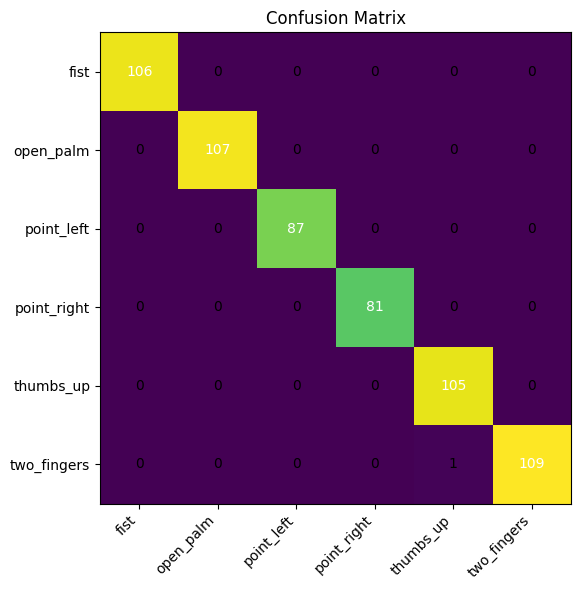

In [4]:
import itertools, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets, models
import torch

device = torch.device('cpu')
tfm = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_ds = datasets.ImageFolder(SPLIT_DIR/'test', transform=tfm)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

ckpt = torch.load(MODEL_CKPT, map_location=device)
classes = ckpt['classes']

model = models.resnet18(weights=None)
import torch.nn as nn
model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.fc.in_features, len(classes)))
model.load_state_dict(ckpt['state_dict'])
model.to(device); model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right'); ax.set_yticklabels(classes)
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout(); plt.show()


## 6) (Optional) Export to ONNX
This makes my model portable to C++ runtimes (e.g., ONNX Runtime, TensorRT).

In [9]:
import torch
from torchvision import models

ckpt = torch.load(MODEL_CKPT, map_location='cpu')
classes = ckpt['classes']

model = models.resnet18(weights=None)
import torch.nn as nn
model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.fc.in_features, len(classes)))
model.load_state_dict(ckpt['state_dict'])
model.eval()

dummy = torch.randn(1,3,IMSIZE,IMSIZE)
torch.onnx.export(model, dummy, 'gesture_resnet18.onnx',
                  input_names=['input'], output_names=['logits'],
                  opset_version=12,
                  dynamic_axes={'input':{0:'batch'}, 'logits':{0:'batch'}})
print('Exported gesture_resnet18.onnx')


Exported gesture_resnet18.onnx


## 7) Arduino serial sanity check
Quick test to make sure the notebook can talk to the Arduino Mega. Update the `PORT` and run.
Close the Arduino Serial Monitor before running (it locks the port).

In [ ]:
import serial, time

PORT = '/dev/tty.usbmodem14101'  # change to your port (I just put a random one for now)
BAUD = 115200

ser = serial.Serial(PORT, BAUD, timeout=0.05)
time.sleep(2)

# Example: send two opcodes (you map these in your Arduino sketch)
ser.write(bytes([0x01]))  # e.g., GO_FWD
time.sleep(0.2)
ser.write(bytes([0x02]))  # e.g., STOP_EMERGENCY

ser.close()
print('Sent test opcodes')


## 8) Realtime webcam inference → Serial to Arduino
Here I run the model in a loop, predict the gesture, apply a bit of temporal smoothing,
and send **one byte** to the Mega whenever the prediction stabilizes (not finished). Press **q** to quit the window.

In [ ]:
import cv2, torch, time, serial, numpy as np
from torchvision import models, transforms
from PIL import Image

# SERIAL
PORT = '/dev/tty.usbmodem14101'   # change me lmao
BAUD = 115200
ser = serial.Serial(PORT, BAUD, timeout=0.02)
time.sleep(2)

#MODEL 
ckpt = torch.load(MODEL_CKPT, map_location='cpu')
classes = ckpt['classes']

model = models.resnet18(weights=None)
import torch.nn as nn
model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.fc.in_features, len(classes)))
model.load_state_dict(ckpt['state_dict'])
model.eval()

OP = {  # map class to opcode
  'open_palm':0x01, 'fist':0x02, 'thumbs_up':0x03,
  'two_fingers':0x04, 'point_left':0x05, 'point_right':0x06
}

tfm = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

cap = cv2.VideoCapture(0)
hist, last_sent = [], None
print('Realtime running. Press q to quit.')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            print('Unable to grab frame.'); break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        inp = tfm(Image.fromarray(rgb)).unsqueeze(0)

        with torch.no_grad():
            logits = model(inp)
            probs = torch.softmax(logits, dim=1).numpy()[0]
        idx = int(np.argmax(probs))
        label, conf = classes[idx], float(probs[idx])

        # Temporal smoothing: majority over last 9 frames + confidence threshold
        hist.append(label); hist = hist[-9:]
        stable = (hist.count(hist[-1]) >= 5) and (conf >= 0.70)

        if stable:
            code = OP[label]
            if code != last_sent:
                ser.write(bytes([code]))
                last_sent = code

        # Overlay
        cv2.putText(frame, f"{label} ({conf:.2f})", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Realtime', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release(); cv2.destroyAllWindows(); ser.close()


## 9) Tips & Troubleshooting
- **Port busy**: close Arduino Serial Monitor; only one program can open the port.
- **Permission denied (Linux)**: `sudo usermod -a -G dialout $USER` then log out/in.
- **No webcam window**: some environments block GUI windows; run locally or adapt to inline display.
- **Unstable predictions**: add more data for confused classes, or increase smoothing (larger history / higher confidence).